In [1]:
# !pip3 install tensorflow-metal==0.5.0 tensorflow-macos==2.11

In [1]:
# data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# audio handling and visualization
import librosa, librosa.display

# nn
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

# time
import time
import datetime

In [2]:
print(pd.__version__)
print(tf.__version__)

1.5.0
2.11.0


In [3]:
import psutil
psutil.virtual_memory()

svmem(total=8589934592, available=2221441024, percent=74.1, used=3851190272, free=33521664, active=2206203904, inactive=2057535488, wired=1644986368)

In [4]:
(psutil.Process().memory_info().rss / (1024**2))/1000

0.467171875

In [17]:
df = pd.read_csv("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/dataset_file_directory.csv")
df

,Filename,Participant,Label
0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick
1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick
2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick
3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick
4,200126_2142_00-00-24.55--00-00-24.95.wav,P01,dysregulation-sick
...,...,...,...
7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted
7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted
7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted
7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted


In [6]:
from playsound import playsound
def play(sound):
    '''
    Plays sound using playsound()
    @params
    - sound: DF sample with audio file to play (str)
    '''
    # ! path to where you store data
    data_path="/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/"
    print(sound.Label)
    playsound(f"{data_path}{str(sound.Filename)}")

def pth(file):
    return (f"/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/{file}")

In [7]:
df.query("Label=='delighted'")

,Filename,Participant,Label
1351,200321_1526_00-02-20.92--00-02-21.51.wav,P01,delighted
1352,200307_1826_00-02-32.03--00-02-33.73.wav,P01,delighted
1353,200529_1029_00-00-49.14--00-00-56.3.wav,P01,delighted
1354,200202_1819_00-00-59.12--00-01-00.86698.wav,P01,delighted
1355,200529_1029_00-00-39.89--00-00-40.42.wav,P01,delighted
...,...,...,...
7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted
7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted
7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted
7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted


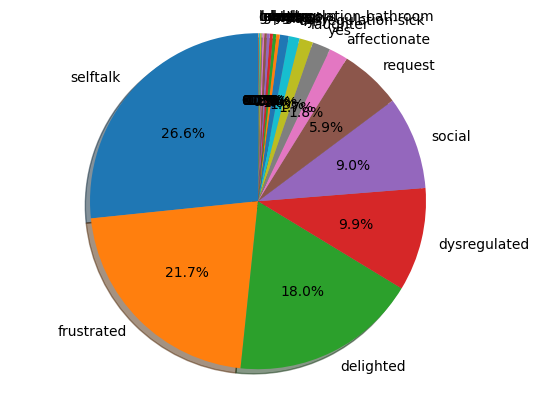

In [8]:
# label splits
labels = ['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social', 'request', 'affectionate', 'yes', 'laughter', 'dysregulation-sick', 'happy', 'help', 'more', 'protest', 'bathroom', 'dysregulation-bathroom', 'no', 'glee', 'laugh', 'tablet', 'hunger', 'greeting']
sizes = list(df.Label.value_counts())
explode = np.zeros(len(labels))
explode[0] = 1
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

# Preprocessing

Input features: 

1. FFT
2. Spectrogram
3. MFCCs

https://www.youtube.com/watch?v=Oa_d-zaUti8&ab_channel=ValerioVelardo-TheSoundofAI


### Cleaning

In [23]:
# keep count of how many occourences of label, use for filtering later
def label_count(label, df):
    return df['Label'].value_counts()[label]

df['count']=df['Label'].apply(lambda label: label_count(label, df))
df

,Filename,Participant,Label,count
0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick,74
1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick,74
2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick,74
3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick,74
4,200126_2142_00-00-24.55--00-00-24.95.wav,P01,dysregulation-sick,74
...,...,...,...,...
7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted,1272
7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted,1272
7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted,1272
7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted,1272


In [24]:
df.Label.value_counts()

selftalk                  1885
frustrated                1536
delighted                 1272
dysregulated               704
social                     634
request                    419
affectionate               129
yes                        123
laughter                    93
dysregulation-sick          74
happy                       61
help                        24
more                        22
protest                     21
bathroom                    20
dysregulation-bathroom      18
no                          12
glee                         8
laugh                        8
tablet                       7
hunger                       4
greeting                     3
Name: Label, dtype: int64

In [27]:
df=df[df['count']>50]
df

,Filename,Participant,Label,count
0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick,74
1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick,74
2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick,74
3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick,74
4,200126_2142_00-00-24.55--00-00-24.95.wav,P01,dysregulation-sick,74
...,...,...,...,...
7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted,1272
7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted,1272
7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted,1272
7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted,1272


In [28]:
# do not need count
df.drop(columns=['count'])

,Filename,Participant,Label
0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick
1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick
2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick
3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick
4,200126_2142_00-00-24.55--00-00-24.95.wav,P01,dysregulation-sick
...,...,...,...
7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted
7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted
7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted
7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted


### Features

### Waveform

/var/folders/p6/9c98fqb51038xhz870chsj280000gn/T/ipykernel_73970/1511560158.py:2: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sr)


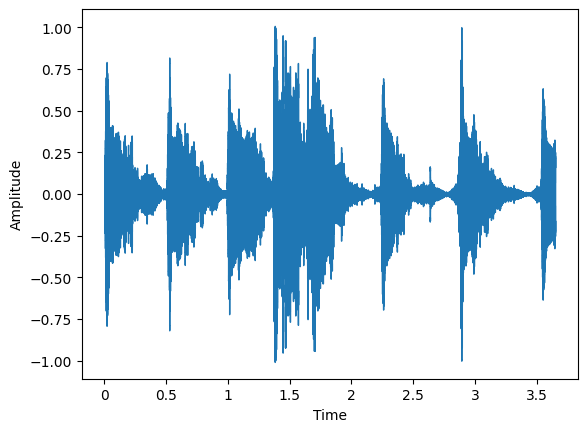

In [12]:
signal, sr = librosa.load(pth(df.iloc[3]['Filename']), sr=22050)
librosa.display.waveshow(signal, sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [13]:
type(librosa.load(pth(df.iloc[3]['Filename']), sr=22050)[0])

numpy.ndarray

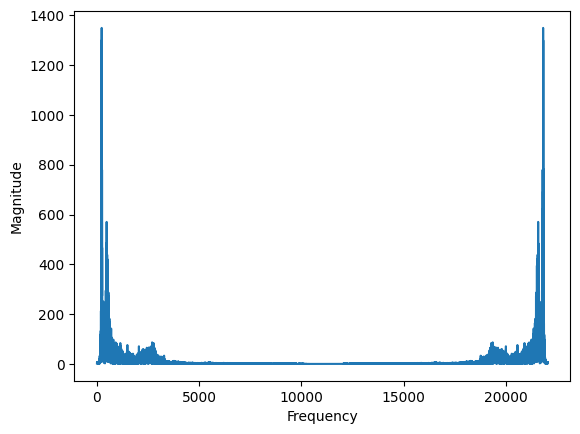

In [14]:
fft = np.fft.fft(signal)
mag = np.abs(fft)
freq = np.linspace(0, sr, len(mag))
plt.plot(freq, mag)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

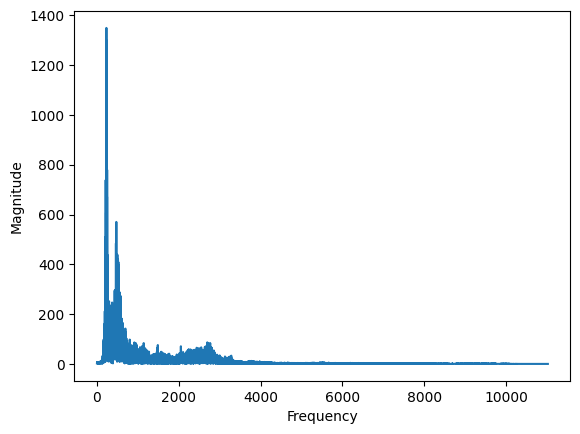

In [15]:
l_freq = freq[:int(len(freq)/2)]
l_mag = mag[:int(len(mag)/2)]
plt.plot(l_freq, l_mag)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### STFT (Spectrogram)

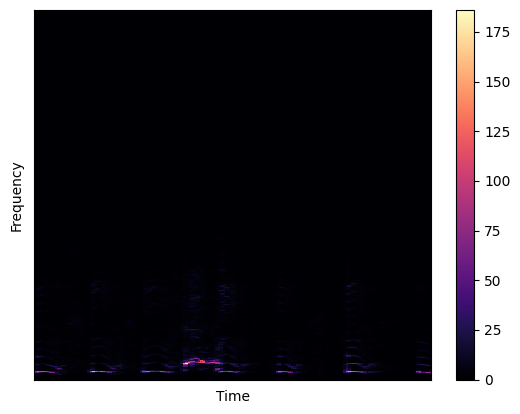

In [16]:
n_fft = 2048
hop = 512

stft = librosa.core.stft(signal, hop_length=hop, n_fft=n_fft)
spectrogram = np.abs(stft)

librosa.display.specshow(spectrogram, sr=sr, hop_length=hop)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

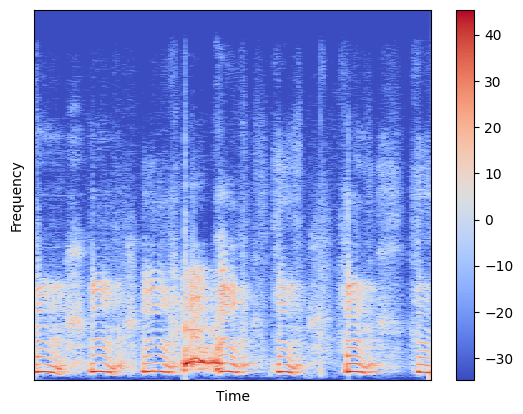

In [17]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs

/var/folders/p6/9c98fqb51038xhz870chsj280000gn/T/ipykernel_73970/4162248523.py:1: FutureWarning: Pass y=[ 0.00380905 -0.00990405 -0.03547914 ...  0.07432524  0.09345954
  0.07701991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mffcs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop, n_mfcc=13)


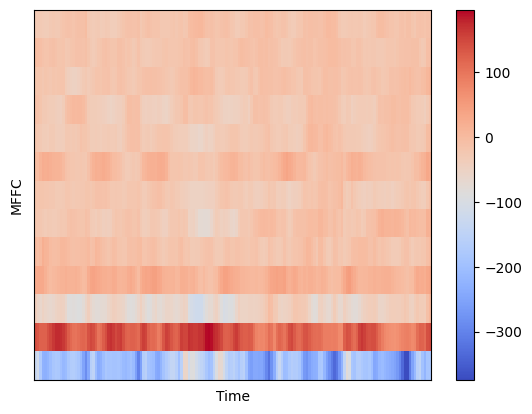

In [18]:
mffcs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop, n_mfcc=13)
librosa.display.specshow(mffcs, sr=sr, hop_length=hop)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

# Preprocessing

1. Extract features
    - signal
    - FFT
    - Magnitude
    - Frequency
    - Left Magnitude (l_mag)
    - Left Frequency (l_freq)
    - STFT
    - Spectrogram
    - Logarithmic Spectrogram (l_spec)
    - MFFC


2. Add padding 
    - Need all individual features to have same number of zeros - use np.zeros to fill in 0s for missing dims

3. Flatten and append all arrays to create embedding
    - Need to have all data with same dims, use PCA to reduce dims for computing efficiency and straight pipeline for one neural network

In [31]:
def signal(row):
    return librosa.load(pth(row.Filename), sr=22050)[0]

def FFT(row):
    return np.fft.fft(row.signal)

def magnitude(row):
    return np.abs(row.fft)

def frequency(row):
    return np.linspace(0, 22050, len(row.mag))

def l_mag(row):
    return row.mag[:int(len(row.mag)/2)]
 
def l_freq(row):
    return row.freq[:int(len(row.freq)/2)]

def STFT(row):
    return librosa.core.stft(row.signal, hop_length=512, n_fft=2048)

def spectrogram(row):
    return np.abs(row.stft)

def log_spec(row):
    return librosa.amplitude_to_db(row.spectrogram)

def MFFC(row):
    return librosa.feature.mfcc(row.signal, n_fft=2048, hop_length=512, n_mfcc=13)

def preprocess(df):
    df['signal'] = df.apply(signal, axis=1)
    df['fft'] = df.apply(FFT, axis=1)
    df['mag'] = df.apply(magnitude, axis=1)
    df['freq'] = df.apply(frequency, axis=1)
    df['l_mag'] = df.apply(l_mag, axis=1)
    df['l_freq'] = df.apply(l_freq, axis=1)
    df['stft'] = df.apply(STFT, axis=1)
    df['spectrogram'] = df.apply(spectrogram, axis=1)
    df['log_spec'] = df.apply(log_spec, axis=1)
    df['mffc'] = df.apply(MFFC, axis=1)

    return df

In [ ]:
%%time
df = preprocess(df)

In [33]:
# save df
df.to_pickle("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/preprocessed_data.pickle")

In [18]:
# load data
df=pd.read_pickle("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/preprocessed_data.pickle")

: 

: 

#### Add padding for each participant seperately => less resources used at a time

In [12]:
# add padding to data for dimensions to match 
def max_dim(column):
    return max(arr.shape for arr in column)

def PAD(a, dim):
    b=np.zeros(dim)
    if len(dim)==1:
        b[:a.shape[0]]=a
    else:
        b[:a.shape[0],:a.shape[1]]=a

    return b

In [10]:
def PAD_df(df):
    df['signal']=df['signal'].apply(lambda a: PAD(a, max_dim(df['signal'])))
    df['fft']=df['fft'].apply(lambda a: PAD(a, max_dim(df['fft'])))
    df['l_mag']=df['l_mag'].apply(lambda a: PAD(a, max_dim(df['l_mag'])))
    df['l_freq']=df['l_freq'].apply(lambda a: PAD(a, max_dim(df['l_freq'])))
    df['stft']=df['stft'].apply(lambda a: PAD(a, max_dim(df['stft'])))
    df['log_spec']=df['log_spec'].apply(lambda a: PAD(a, max_dim(df['log_spec'])))
    df['mffc']=df['mffc'].apply(lambda a: PAD(a, max_dim(df['mffc'])))

    return df


### Use P01, P02, P03

In [ ]:
df01=df.query("Participant=='P01'")
df01=PAD_df(df01)
df01.to_pickle("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/p01.pickle")

In [ ]:
df02=df.query("Participant=='P02'")
df02=PAD_df(df02)
df02.to_pickle("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/p02.pickle")

In [12]:
df03=df.query("Participant=='P03'")
df03=PAD_df(df03)
df03.to_pickle("/Users/visheshnarayan/Documents/Autism Research/VocalClassification/data/p03.pickle")

### Embeddings
1. Flatten necessary data
2. Append all together

In [4]:
def embedding(row):
    embed=np.concatenate((
        row['signal'],
        row['fft'],
        row['l_mag'],
        row['l_freq'],
        row['stft'].flatten(),
        row['log_spec'].flatten(),
        row['mffc'].flatten()))
    return embed

In [55]:
df['embed']=df.apply(embedding, axis=1)

# Create Model

**NN steps**
- create Dr j. NN
- create one of own

**Data steps**
1. split data based on participant
2. create train test splits
3. train + test (use f1 metric)
4. visualize results

In [3]:
# start with p03
df=pd.read_pickle(f"/Users/visheshnarayan/Documents/Autism Research/preprocessed_pickles/p03_embeds.pickle")

# encode labels
le=LabelEncoder()
le.fit(df['Label'])
df['Label']=le.transform(df['Label'])
df.Label.value_counts()

1    302
3     61
4     55
2     47
0     25
Name: Label, dtype: int64

In [4]:
# initialize model
model = Sequential()

# input layer -> hidden1
model.add(Dense(128, activation='relu', input_shape=(960291,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# hidden2
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# hidden3
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# output layer
model.add(Dense(5, activation='softmax', input_shape=(128,)))

# hyperparameters
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy('accuracy'),
        tf.keras.metrics.SparseCategoricalCrossentropy()])

# summary
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-04 20:40:53.790703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 20:40:53.791276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               122917376 
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [5]:
# import features and target
X=df['embed'].to_numpy()
y=df['Label'].to_numpy()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# reshape for input
X_train = np.array([np.array(val) for val in X_train])
y_train = np.array([np.array(val) for val in y_train])
X_test = np.array([np.array(val) for val in X_train])
y_test = np.array([np.array(val) for val in y_train])

# check shapes
print(X_train.shape)
print(y_train.shape)

(343, 960291)
(343,)


In [6]:
# clean memory
del df
del X
del y

In [7]:
# tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# fit data
history=model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback])

Epoch 1/100


2023-01-04 20:41:53.877997: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/homebrew/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-04 20:41:55.736714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2.3711 - accuracy: 0.2263 - sparse_categorical_crossentropy: 2.3711

2023-01-04 20:42:07.607884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 46s 2s/step - loss: 2.3711 - accuracy: 0.2263 - sparse_categorical_crossentropy: 2.3711 - val_loss: 3.1585 - val_accuracy: 0.1159 - val_sparse_categorical_crossentropy: 3.1585
Epoch 2/100
18/18 [==============================] - 43s 2s/step - loss: 2.1029 - accuracy: 0.2263 - sparse_categorical_crossentropy: 2.1029 - val_loss: 2.2026 - val_accuracy: 0.3768 - val_sparse_categorical_crossentropy: 2.2026
Epoch 3/100
18/18 [==============================] - 43s 2s/step - loss: 1.9364 - accuracy: 0.3066 - sparse_categorical_crossentropy: 1.9364 - val_loss: 2.0025 - val_accuracy: 0.4058 - val_sparse_categorical_crossentropy: 2.0025
Epoch 4/100
18/18 [==============================] - 43s 2s/step - loss: 1.8960 - accuracy: 0.2591 - sparse_categorical_crossentropy: 1.8960 - val_loss: 1.7435 - val_accuracy: 0.4928 - val_sparse_categorical_crossentropy: 1.7435
Epoch 5/100
18/18 [==============================] - 44s 2s/step - loss: 1.8981 - accuracy: 0.32